# Variational Autoencoders (VAEs)

## 🎯 Motivation: Image Generation

We want to build a model that can **generate realistic images** — like cats, digits, or landscapes.

Formally, this means sampling from some unknown data distribution:

$$
x \sim p(x)
$$

But the true distribution $p(x)$ over images is **unknown and highly complex**. So we want to **learn an approximate model** that can:

- Learn the structure of the data
- Generate new, realistic samples
- Explore different architectures (MLP and CNN) for this task

---

## 🧠 Latent Variable Models

Instead of modeling $p(x)$ directly, we assume there's an **unobserved latent variable** $z$ that generates $x$.

We define a **generative model**:

$$
p_\theta(x, z) = p_\theta(x \mid z) \, p(z)
$$

- $p(z)$ is the **prior** over latent variables (usually standard normal)
- $p_\theta(x \mid z)$ is the **likelihood** or **decoder**, implemented as a neural network

The marginal likelihood is:

$$
p_\theta(x) = \int p_\theta(x \mid z) p(z) \, dz
$$

This model can **generate new images** by:

1. Sampling $z \sim p(z)$  
2. Computing $x \sim p_\theta(x \mid z)$

---

## 🚧 The Training Problem: Why We Need the Integral

To train our generative model, we want to learn parameters $\theta$ that make our training data likely. This requires maximizing:

$$
\mathcal{L}(\theta) = \sum_{i=1}^N \log p_\theta(x_i)
$$

But computing $p_\theta(x)$ requires the intractable integral:

$$
p_\theta(x) = \int p_\theta(x \mid z) p(z) \, dz
$$

This integral is **intractable** because:

- $p_\theta(x \mid z)$ is defined by a neural network (not analytically integrable)
- $z$ is high-dimensional (integration over high-dimensional spaces is computationally infeasible)

This also makes the **posterior** $p(z \mid x)$ intractable:

$$
p(z \mid x) = \frac{p_\theta(x \mid z) p(z)}{p_\theta(x)}
$$

So we can't use exact maximum likelihood training.

---

## 💡 Variational Inference

In latent variable models like VAEs, we define a joint distribution:

$$
p_\theta(x, z) = p_\theta(x \mid z) \, p(z)
$$

To compute the data likelihood, we marginalize over the latent variable:

$$
\log p_\theta(x) = \log \int p_\theta(x, z) \, dz
$$

This integral is typically intractable, so we apply **importance sampling** using an approximate posterior $q_\phi(z \mid x)$:

$$
\log p_\theta(x) 
= \log \int \frac{q_\phi(z \mid x)}{q_\phi(z \mid x)} \, p_\theta(x, z) \, dz
= \log \mathbb{E}_{q_\phi(z \mid x)} \left[ \frac{p_\theta(x, z)}{q_\phi(z \mid x)} \right]
$$

By **Jensen’s inequality**, we lower-bound the log of this expectation:

$$
\log p_\theta(x) 
\geq \mathbb{E}_{q_\phi(z \mid x)} \left[ \log \frac{p_\theta(x, z)}{q_\phi(z \mid x)} \right]
$$

This gives the **Evidence Lower Bound (ELBO)**:

$$
\log p_\theta(x) 
\geq 
\underbrace{
\mathbb{E}_{q_\phi(z \mid x)} \left[ \log p_\theta(x \mid z) \right]
}_{\text{Reconstruction term}} 
\;\; - \;\;
\underbrace{
D_{\text{KL}}\left( q_\phi(z \mid x) \,\|\, p(z) \right)
}_{\text{Regularization (KL) term}}
$$

- The **reconstruction term** encourages the decoder to explain the data well
- The **KL term** keeps the approximate posterior close to the prior

This ELBO is the objective we optimize when training VAEs.



---

## 🔧 VAE Loss Function

The variational objective we optimize is:

$$
\mathcal{L}_{\text{VAE}}(x) = - \mathbb{E}_{q_\phi(z \mid x)}[\log p_\theta(x \mid z)] + D_{\text{KL}}(q_\phi(z \mid x) \,\|\, p(z))
$$

This balances:

- How well the model **reconstructs** the input from latent $z$
- How close the learned posterior is to the **prior**

## 🔁 Reparameterization Trick

To train the encoder using gradient descent, we need to compute gradients of the ELBO with respect to its parameters $\phi$:

$$
\nabla_\phi \; \mathbb{E}_{z \sim q_\phi(z \mid x)}[\log p_\theta(x \mid z)]
$$

However, directly sampling from $q_\phi(z \mid x)$ — which is a learned Gaussian — breaks the computation graph, because sampling is a non-differentiable operation.

We assume the encoder outputs a **diagonal Gaussian posterior**:

$$
q_\phi(z \mid x) = \mathcal{N}(z; \mu_\phi(x), \text{diag}(\sigma^2_\phi(x)))
$$

To enable gradient flow, we apply the **reparameterization trick**. Instead of sampling $z$ directly from $q_\phi(z \mid x)$, we:

1. Sample noise from a standard normal: $\epsilon \sim \mathcal{N}(0, I)$  
2. Transform it using the encoder outputs:

$$
z = \mu_\phi(x) + \sigma_\phi(x) \cdot \epsilon
$$

This transforms the stochastic operation into a **deterministic and differentiable function** of $\phi$, while keeping the randomness external via $\epsilon$.

Now, the expectation becomes:

$$
\mathbb{E}_{\epsilon \sim \mathcal{N}(0, I)} \left[ \log p_\theta(x \mid \mu_\phi(x) + \sigma_\phi(x) \cdot \epsilon) \right]
$$

This version is differentiable with respect to $\phi$, so we can use standard gradient-based optimization to train the encoder.

---

## 📏 KL Divergence as a Regularizer

We use a standard normal prior:

$$
p(z) = \mathcal{N}(0, I)
$$

The KL divergence between $q_\phi(z \mid x)$ and $p(z)$ can be computed in closed form:

$$
D_{\text{KL}}(q_\phi(z \mid x) \,\|\, p(z)) = \frac{1}{2} \sum_{j=1}^{d} \left( \mu_j^2 + \sigma_j^2 - \log \sigma_j^2 - 1 \right)
$$

This term encourages the latent space to stay close to the prior — it acts as a **regularizer**.

---


## 🧪 Monte Carlo Estimation of the ELBO

The expectation in the reconstruction term of the ELBO:

$$
\mathbb{E}_{q_\phi(z \mid x)} \left[ \log p_\theta(x \mid z) \right]
$$

is typically estimated using **a single sample** $z^{(1)} \sim q_\phi(z \mid x)$ from the encoder:

$$
\log p_\theta(x \mid z) \approx \log p_\theta(x \mid z^{(1)})
$$

So the final training loss becomes:

$$
\mathcal{L}(x) \approx - \log p_\theta(x \mid z^{(1)}) + D_{\text{KL}}(q_\phi(z \mid x) \,\|\, p(z))
$$

The form of the **log-likelihood** term $\log p_\theta(x \mid z)$ depends on the assumed likelihood distribution.

---

### 📘 Case 1: Bernoulli Likelihood

If we assume each pixel $x_i$ is a Bernoulli random variable:

$$
p_\theta(x \mid z) = \prod_{i=1}^D \text{Bernoulli}(x_i; \hat{x}_i)
$$

Where $\hat{x}_i \in [0, 1]$ is the decoder's output (after sigmoid activation). Then:

$$
\log p_\theta(x \mid z) = \sum_{i=1}^D \left[ x_i \log \hat{x}_i + (1 - x_i) \log (1 - \hat{x}_i) \right]
$$

This is the **binary cross-entropy (BCE)** loss.

---

### 📘 Case 2: Gaussian Likelihood

If we assume each pixel $x_i$ is drawn from a Gaussian with fixed unit variance:

$$
p_\theta(x \mid z) = \mathcal{N}(x; \hat{x}, I)
$$

Then the log-likelihood is:

$$
\log p_\theta(x \mid z) = -\frac{1}{2} \|x - \hat{x}\|^2 + \text{const}
$$

Maximizing the log-likelihood is equivalent to **minimizing the mean squared error (MSE)** between $x$ and $\hat{x}$.

---

In both cases, the reconstruction loss corresponds to the **negative log-likelihood** under the chosen decoder distribution.

This notebook will demonstrate VAEs using both: 
- **Multi-Layer Perceptrons (MLPs)**: A basic VAE structure.
- **Convolutional Neural Networks (CNNs)**: An architecture better suited for image data, leveraging spatial hierarchies.

We will implement VAEs with both Bernoulli and Gaussian likelihoods for the decoder, and compare their performance on the MNIST dataset.

## References

- [Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114)

### Code example for Bernoulli and Gaussian likelihood

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


# MLP Encoder: x -> z (mean and logvar)
class Encoder(nn.Module):
    def __init__(
        self, input_dim=784, hidden_dim=256, latent_dim=20
    ):  # hidden_dim adjusted
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar


# MLP Decoder: z -> x_hat
class Decoder(nn.Module):
    def __init__(
        self,
        latent_dim=20,
        hidden_dim=256,
        output_dim=784,
        likelihood="bernoulli",  # hidden_dim adjusted
    ):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.likelihood = likelihood

    def forward(self, z):
        h = F.relu(self.fc1(z))
        out = self.fc_out(h)
        if self.likelihood == "bernoulli":
            return torch.sigmoid(out)
        else:  # "gaussian"
            return out


class MLPVAE(nn.Module):
    def __init__(
        self,
        input_dim=784,
        hidden_dim=256,
        latent_dim=20,
        likelihood="bernoulli",  # hidden_dim adjusted
    ):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim, likelihood)
        self.likelihood = likelihood

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar


# CNN Encoder: x -> z (mean and logvar)
class ConvEncoder(nn.Module):
    def __init__(self, latent_dim=40, in_channels=1):  # latent_dim adjusted
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels, 32, kernel_size=3, stride=2, padding=1
        )  # 28x28 -> 14x14
        self.conv2 = nn.Conv2d(
            32, 64, kernel_size=3, stride=2, padding=1
        )  # 14x14 -> 7x7
        self.conv3 = nn.Conv2d(
            64, 128, kernel_size=3, stride=2, padding=1
        )  # 7x7 -> 4x4
        self.flat_size = 128 * 4 * 4
        self.fc_mu = nn.Linear(self.flat_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flat_size, latent_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar


# CNN Decoder: z -> x_hat
class ConvDecoder(nn.Module):
    def __init__(
        self, latent_dim=40, out_channels=1, likelihood="bernoulli"
    ):  # latent_dim adjusted
        super().__init__()
        self.likelihood = likelihood
        self.fc = nn.Linear(latent_dim, 128 * 4 * 4)  # Project to 128x4x4
        # Upsample: 4x4 -> 8x8 -> 16x16 -> 28x28
        self.deconv1 = nn.ConvTranspose2d(
            128, 64, kernel_size=4, stride=2, padding=1
        )  # 4x4 -> 8x8
        self.deconv2 = nn.ConvTranspose2d(
            64, 32, kernel_size=4, stride=2, padding=1
        )  # 8x8 -> 16x16
        self.deconv3 = nn.ConvTranspose2d(
            32, out_channels, kernel_size=4, stride=2, padding=3, output_padding=0
        )  # 16x16 -> 28x28

    def forward(self, z):
        x = self.fc(z)
        x = x.view(x.size(0), 128, 4, 4)  # Reshape to [B, 128, 4, 4]
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = self.deconv3(x)
        if self.likelihood == "bernoulli":
            return torch.sigmoid(x)
        else:  # "gaussian"
            return x


class CNNVAE(nn.Module):
    def __init__(
        self, latent_dim=40, in_channels=1, likelihood="bernoulli"
    ):  # latent_dim adjusted
        super().__init__()
        self.encoder = ConvEncoder(latent_dim, in_channels)
        self.decoder = ConvDecoder(latent_dim, in_channels, likelihood)
        self.likelihood = likelihood

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar


# Common VAE Loss function
def vae_loss(x, x_hat, mu, logvar, likelihood="bernoulli"):
    if likelihood == "bernoulli":
        recon_loss = F.binary_cross_entropy(x_hat, x, reduction="sum")
    elif likelihood == "gaussian":
        recon_loss = F.mse_loss(x_hat, x, reduction="sum")
    else:
        raise ValueError(f"Unknown likelihood type: {likelihood}")

    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss


# Unified Training Function
def run_experiment(
    model_type: str,
    likelihood: str,
    epochs: int,
    batch_size: int,
    latent_dim: int,
    lr: float = 1e-3,
    show_every: int = 10,
    mlp_hidden_dim: int = 256,  # Default adjusted for param count
):
    print(f"\n--- Starting Experiment ---")
    print(f"Model Type: {model_type.upper()}, Likelihood: {likelihood.capitalize()}")
    print(
        f"Epochs: {epochs}, Batch Size: {batch_size}, Latent Dim: {latent_dim}, LR: {lr}"
    )
    if model_type == "mlp":
        print(f"MLP Hidden Dim: {mlp_hidden_dim}")

    transform = transforms.ToTensor()  # Normalizes to [0,1]
    train_loader = DataLoader(
        datasets.MNIST(root="./data", train=True, download=True, transform=transform),
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,  # Added for potentially faster data loading
        pin_memory=(
            True if torch.cuda.is_available() else False
        ),  # Added for potentially faster data loading
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    if model_type == "mlp":
        vae_model = MLPVAE(
            input_dim=784,  # MNIST specific
            hidden_dim=mlp_hidden_dim,
            latent_dim=latent_dim,
            likelihood=likelihood,
        ).to(device)
    elif model_type == "cnn":
        vae_model = CNNVAE(
            latent_dim=latent_dim,
            in_channels=1,  # MNIST specific
            likelihood=likelihood,
        ).to(device)
    else:
        raise ValueError(f"Unknown model_type: {model_type}")

    num_params = sum(p.numel() for p in vae_model.parameters() if p.requires_grad)
    print(f"Trainable Parameters: {num_params:,}")

    optimizer = torch.optim.Adam(vae_model.parameters(), lr=lr)

    for epoch in range(epochs):
        vae_model.train()
        total_loss = 0
        for x_orig, _ in train_loader:
            x = x_orig.to(device)
            if model_type == "mlp":
                x_input = x.view(-1, 784)  # Flatten for MLP
                target_x = x_input  # Loss target is also flattened
            else:  # CNN
                x_input = x  # CNN expects [B, C, H, W]
                target_x = x  # Loss target is also [B, C, H, W]

            x_hat, mu, logvar = vae_model(x_input)

            loss = vae_loss(target_x, x_hat, mu, logvar, likelihood)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs}, Avg Loss: {avg_loss:.4f}")

        if (epoch + 1) % show_every == 0 or epoch == epochs - 1:
            vae_model.eval()
            with torch.no_grad():
                z_sample = torch.randn(16, latent_dim).to(device)  # Generate 16 samples
                generated_samples = vae_model.decoder(z_sample)

                if model_type == "mlp":
                    generated_samples = generated_samples.cpu().view(-1, 1, 28, 28)
                else:
                    generated_samples = generated_samples.cpu()

                # Normalize for visualization if Gaussian (raw output)
                # Bernoulli output is already [0,1] via sigmoid
                grid = torchvision.utils.make_grid(
                    generated_samples,
                    nrow=4,
                    normalize=(likelihood == "gaussian"),
                    value_range=(0, 1) if likelihood == "gaussian" else None,
                )

                plt.figure(figsize=(6, 6))  # Standardized figure size
                plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap="gray")
                title_str = f"Generated Samples ({model_type.upper()}, {likelihood.capitalize()})\nEpoch {epoch+1}"
                plt.title(title_str)
                plt.axis("off")
                plt.show()
    print(
        f"--- Experiment Finished: {model_type.upper()}, {likelihood.capitalize()} ---"
    )


--- Starting Experiment ---
Model Type: MLP, Likelihood: Bernoulli
Epochs: 100, Batch Size: 1024, Latent Dim: 20, LR: 0.001
MLP Hidden Dim: 256
Using device: cuda
Trainable Parameters: 418,104
Epoch 1/100, Avg Loss: 276.6357
Epoch 1/100, Avg Loss: 276.6357
Epoch 2/100, Avg Loss: 197.8746
Epoch 2/100, Avg Loss: 197.8746
Epoch 3/100, Avg Loss: 170.1065
Epoch 3/100, Avg Loss: 170.1065
Epoch 4/100, Avg Loss: 155.2735
Epoch 4/100, Avg Loss: 155.2735
Epoch 5/100, Avg Loss: 144.6444
Epoch 5/100, Avg Loss: 144.6444
Epoch 6/100, Avg Loss: 137.8460
Epoch 6/100, Avg Loss: 137.8460
Epoch 7/100, Avg Loss: 132.6371
Epoch 7/100, Avg Loss: 132.6371
Epoch 8/100, Avg Loss: 128.6454
Epoch 8/100, Avg Loss: 128.6454
Epoch 9/100, Avg Loss: 125.6076
Epoch 9/100, Avg Loss: 125.6076
Epoch 10/100, Avg Loss: 123.2575
Epoch 10/100, Avg Loss: 123.2575
Epoch 11/100, Avg Loss: 121.3337
Epoch 11/100, Avg Loss: 121.3337
Epoch 12/100, Avg Loss: 119.7873
Epoch 12/100, Avg Loss: 119.7873
Epoch 13/100, Avg Loss: 118.5325

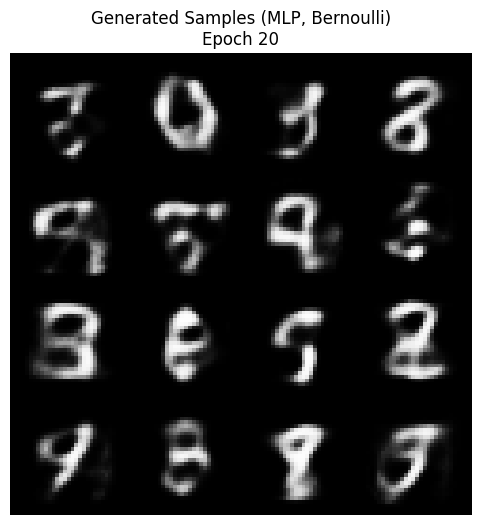

Epoch 21/100, Avg Loss: 112.8968
Epoch 22/100, Avg Loss: 112.4608
Epoch 22/100, Avg Loss: 112.4608
Epoch 23/100, Avg Loss: 112.0584
Epoch 23/100, Avg Loss: 112.0584
Epoch 24/100, Avg Loss: 111.7371
Epoch 24/100, Avg Loss: 111.7371
Epoch 25/100, Avg Loss: 111.4217
Epoch 25/100, Avg Loss: 111.4217
Epoch 26/100, Avg Loss: 111.0656
Epoch 26/100, Avg Loss: 111.0656
Epoch 27/100, Avg Loss: 110.7407
Epoch 27/100, Avg Loss: 110.7407
Epoch 28/100, Avg Loss: 110.5590
Epoch 28/100, Avg Loss: 110.5590
Epoch 29/100, Avg Loss: 110.2612
Epoch 29/100, Avg Loss: 110.2612
Epoch 30/100, Avg Loss: 110.0533
Epoch 30/100, Avg Loss: 110.0533
Epoch 31/100, Avg Loss: 109.7524
Epoch 31/100, Avg Loss: 109.7524
Epoch 32/100, Avg Loss: 109.5882
Epoch 32/100, Avg Loss: 109.5882
Epoch 33/100, Avg Loss: 109.3671
Epoch 33/100, Avg Loss: 109.3671
Epoch 34/100, Avg Loss: 109.1335
Epoch 34/100, Avg Loss: 109.1335
Epoch 35/100, Avg Loss: 109.0219
Epoch 35/100, Avg Loss: 109.0219
Epoch 36/100, Avg Loss: 108.8006
Epoch 36/1

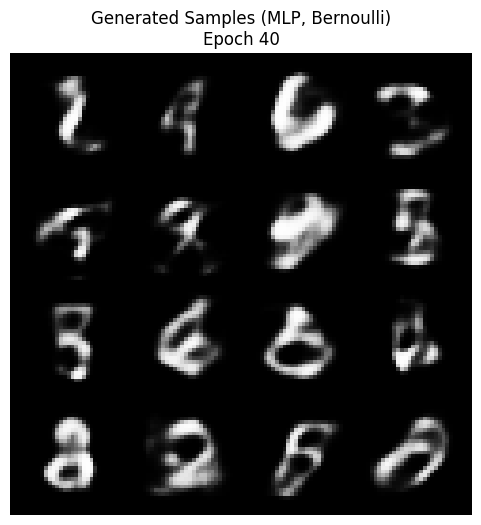

Epoch 41/100, Avg Loss: 108.0547
Epoch 42/100, Avg Loss: 107.8740
Epoch 42/100, Avg Loss: 107.8740
Epoch 43/100, Avg Loss: 107.8193
Epoch 43/100, Avg Loss: 107.8193
Epoch 44/100, Avg Loss: 107.6905
Epoch 44/100, Avg Loss: 107.6905
Epoch 45/100, Avg Loss: 107.5757
Epoch 45/100, Avg Loss: 107.5757
Epoch 46/100, Avg Loss: 107.4488
Epoch 46/100, Avg Loss: 107.4488
Epoch 47/100, Avg Loss: 107.3107
Epoch 47/100, Avg Loss: 107.3107
Epoch 48/100, Avg Loss: 107.2162
Epoch 48/100, Avg Loss: 107.2162
Epoch 49/100, Avg Loss: 107.1320
Epoch 49/100, Avg Loss: 107.1320
Epoch 50/100, Avg Loss: 107.0419
Epoch 50/100, Avg Loss: 107.0419
Epoch 51/100, Avg Loss: 106.8956
Epoch 51/100, Avg Loss: 106.8956
Epoch 52/100, Avg Loss: 106.8604
Epoch 52/100, Avg Loss: 106.8604
Epoch 53/100, Avg Loss: 106.7713
Epoch 53/100, Avg Loss: 106.7713
Epoch 54/100, Avg Loss: 106.6950
Epoch 54/100, Avg Loss: 106.6950
Epoch 55/100, Avg Loss: 106.6305
Epoch 55/100, Avg Loss: 106.6305
Epoch 56/100, Avg Loss: 106.5302
Epoch 56/1

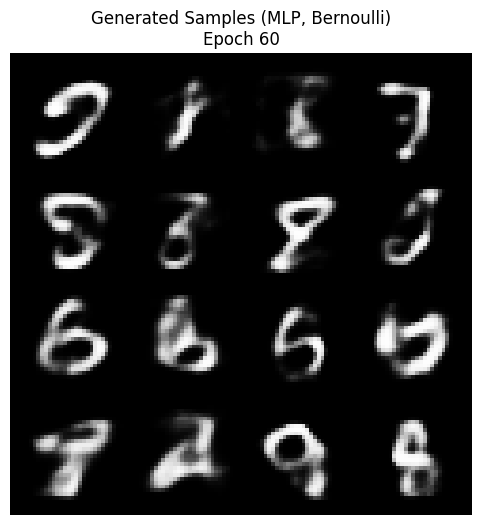

Epoch 61/100, Avg Loss: 106.1783
Epoch 62/100, Avg Loss: 106.0647
Epoch 62/100, Avg Loss: 106.0647
Epoch 63/100, Avg Loss: 105.9981
Epoch 63/100, Avg Loss: 105.9981
Epoch 64/100, Avg Loss: 105.9468
Epoch 64/100, Avg Loss: 105.9468
Epoch 65/100, Avg Loss: 105.8461
Epoch 65/100, Avg Loss: 105.8461
Epoch 66/100, Avg Loss: 105.7773
Epoch 66/100, Avg Loss: 105.7773
Epoch 67/100, Avg Loss: 105.7710
Epoch 67/100, Avg Loss: 105.7710
Epoch 68/100, Avg Loss: 105.6959
Epoch 68/100, Avg Loss: 105.6959
Epoch 69/100, Avg Loss: 105.6199
Epoch 69/100, Avg Loss: 105.6199
Epoch 70/100, Avg Loss: 105.5954
Epoch 70/100, Avg Loss: 105.5954
Epoch 71/100, Avg Loss: 105.5172
Epoch 71/100, Avg Loss: 105.5172
Epoch 72/100, Avg Loss: 105.4584
Epoch 72/100, Avg Loss: 105.4584
Epoch 73/100, Avg Loss: 105.4490
Epoch 73/100, Avg Loss: 105.4490
Epoch 74/100, Avg Loss: 105.3846
Epoch 74/100, Avg Loss: 105.3846
Epoch 75/100, Avg Loss: 105.3242
Epoch 75/100, Avg Loss: 105.3242
Epoch 76/100, Avg Loss: 105.2172
Epoch 76/1

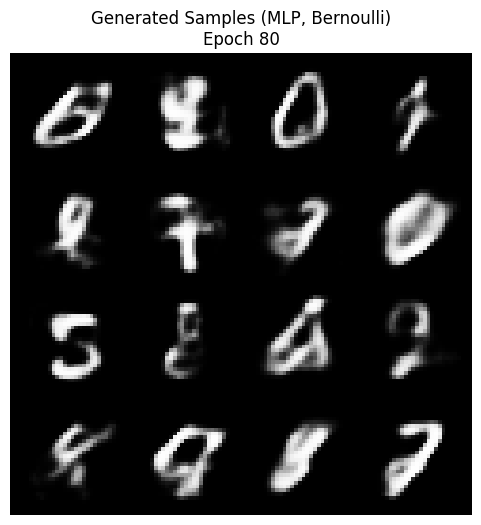

Epoch 81/100, Avg Loss: 105.0639
Epoch 82/100, Avg Loss: 104.9717
Epoch 82/100, Avg Loss: 104.9717
Epoch 83/100, Avg Loss: 104.9471
Epoch 83/100, Avg Loss: 104.9471
Epoch 84/100, Avg Loss: 104.9131
Epoch 84/100, Avg Loss: 104.9131
Epoch 85/100, Avg Loss: 104.8567
Epoch 85/100, Avg Loss: 104.8567
Epoch 86/100, Avg Loss: 104.7807
Epoch 86/100, Avg Loss: 104.7807
Epoch 87/100, Avg Loss: 104.7981
Epoch 87/100, Avg Loss: 104.7981
Epoch 88/100, Avg Loss: 104.8159
Epoch 88/100, Avg Loss: 104.8159
Epoch 89/100, Avg Loss: 104.6824
Epoch 89/100, Avg Loss: 104.6824
Epoch 90/100, Avg Loss: 104.6415
Epoch 90/100, Avg Loss: 104.6415
Epoch 91/100, Avg Loss: 104.6604
Epoch 91/100, Avg Loss: 104.6604
Epoch 92/100, Avg Loss: 104.5905
Epoch 92/100, Avg Loss: 104.5905
Epoch 93/100, Avg Loss: 104.5574
Epoch 93/100, Avg Loss: 104.5574
Epoch 94/100, Avg Loss: 104.5438
Epoch 94/100, Avg Loss: 104.5438
Epoch 95/100, Avg Loss: 104.5082
Epoch 95/100, Avg Loss: 104.5082
Epoch 96/100, Avg Loss: 104.4853
Epoch 96/1

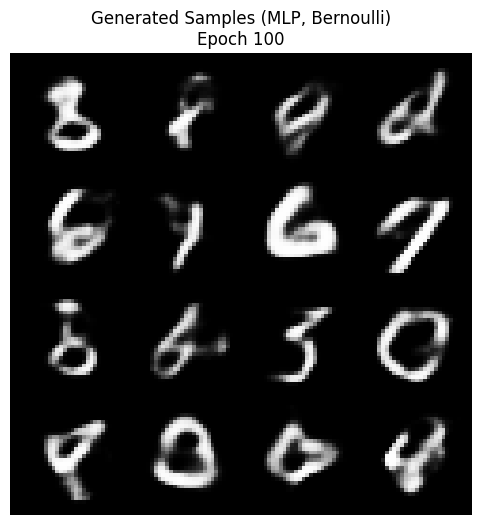

--- Experiment Finished: MLP, Bernoulli ---


In [2]:
# MLP Experiments
run_experiment(
    model_type="mlp",
    likelihood="bernoulli",
    epochs=100,
    batch_size=1024,
    latent_dim=20,
    mlp_hidden_dim=256,
    show_every=20,
    lr=1e-3,
)


--- Starting Experiment ---
Model Type: MLP, Likelihood: Gaussian
Epochs: 100, Batch Size: 1024, Latent Dim: 20, LR: 0.001
MLP Hidden Dim: 256
Using device: cuda
Trainable Parameters: 418,104
Epoch 1/100, Avg Loss: 63.8666
Epoch 1/100, Avg Loss: 63.8666
Epoch 2/100, Avg Loss: 46.0763
Epoch 2/100, Avg Loss: 46.0763
Epoch 3/100, Avg Loss: 41.5032
Epoch 3/100, Avg Loss: 41.5032
Epoch 4/100, Avg Loss: 39.0255
Epoch 4/100, Avg Loss: 39.0255
Epoch 5/100, Avg Loss: 37.4819
Epoch 5/100, Avg Loss: 37.4819
Epoch 6/100, Avg Loss: 36.5057
Epoch 6/100, Avg Loss: 36.5057
Epoch 7/100, Avg Loss: 35.8284
Epoch 7/100, Avg Loss: 35.8284
Epoch 8/100, Avg Loss: 35.3421
Epoch 8/100, Avg Loss: 35.3421
Epoch 9/100, Avg Loss: 34.9573
Epoch 9/100, Avg Loss: 34.9573
Epoch 10/100, Avg Loss: 34.6569
Epoch 10/100, Avg Loss: 34.6569
Epoch 11/100, Avg Loss: 34.3930
Epoch 11/100, Avg Loss: 34.3930
Epoch 12/100, Avg Loss: 34.1931
Epoch 12/100, Avg Loss: 34.1931
Epoch 13/100, Avg Loss: 34.0166
Epoch 13/100, Avg Loss: 3

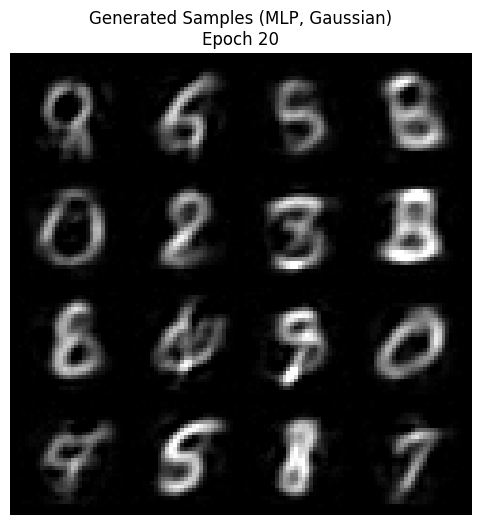

Epoch 21/100, Avg Loss: 32.9689
Epoch 22/100, Avg Loss: 32.8691
Epoch 22/100, Avg Loss: 32.8691
Epoch 23/100, Avg Loss: 32.7813
Epoch 23/100, Avg Loss: 32.7813
Epoch 24/100, Avg Loss: 32.7070
Epoch 24/100, Avg Loss: 32.7070
Epoch 25/100, Avg Loss: 32.5922
Epoch 25/100, Avg Loss: 32.5922
Epoch 26/100, Avg Loss: 32.5439
Epoch 26/100, Avg Loss: 32.5439
Epoch 27/100, Avg Loss: 32.4714
Epoch 27/100, Avg Loss: 32.4714
Epoch 28/100, Avg Loss: 32.3859
Epoch 28/100, Avg Loss: 32.3859
Epoch 29/100, Avg Loss: 32.3140
Epoch 29/100, Avg Loss: 32.3140
Epoch 30/100, Avg Loss: 32.2478
Epoch 30/100, Avg Loss: 32.2478
Epoch 31/100, Avg Loss: 32.2206
Epoch 31/100, Avg Loss: 32.2206
Epoch 32/100, Avg Loss: 32.1637
Epoch 32/100, Avg Loss: 32.1637
Epoch 33/100, Avg Loss: 32.0715
Epoch 33/100, Avg Loss: 32.0715
Epoch 34/100, Avg Loss: 32.0164
Epoch 34/100, Avg Loss: 32.0164
Epoch 35/100, Avg Loss: 31.9852
Epoch 35/100, Avg Loss: 31.9852
Epoch 36/100, Avg Loss: 31.9502
Epoch 36/100, Avg Loss: 31.9502
Epoch 37

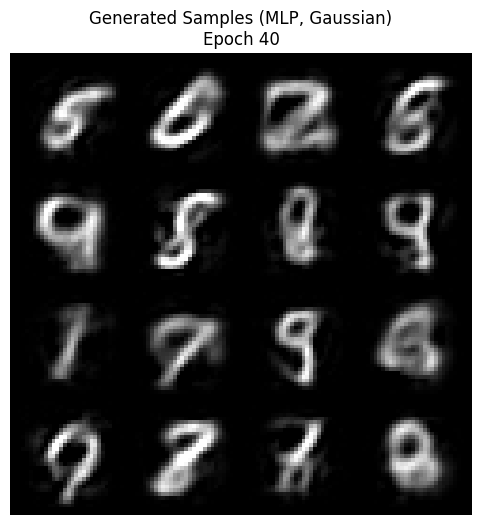

Epoch 41/100, Avg Loss: 31.7447
Epoch 42/100, Avg Loss: 31.7064
Epoch 42/100, Avg Loss: 31.7064
Epoch 43/100, Avg Loss: 31.6872
Epoch 43/100, Avg Loss: 31.6872
Epoch 44/100, Avg Loss: 31.6373
Epoch 44/100, Avg Loss: 31.6373
Epoch 45/100, Avg Loss: 31.5639
Epoch 45/100, Avg Loss: 31.5639
Epoch 46/100, Avg Loss: 31.5705
Epoch 46/100, Avg Loss: 31.5705
Epoch 47/100, Avg Loss: 31.5252
Epoch 47/100, Avg Loss: 31.5252
Epoch 48/100, Avg Loss: 31.5188
Epoch 48/100, Avg Loss: 31.5188
Epoch 49/100, Avg Loss: 31.4758
Epoch 49/100, Avg Loss: 31.4758
Epoch 50/100, Avg Loss: 31.4667
Epoch 50/100, Avg Loss: 31.4667
Epoch 51/100, Avg Loss: 31.4107
Epoch 51/100, Avg Loss: 31.4107
Epoch 52/100, Avg Loss: 31.4066
Epoch 52/100, Avg Loss: 31.4066
Epoch 53/100, Avg Loss: 31.3805
Epoch 53/100, Avg Loss: 31.3805
Epoch 54/100, Avg Loss: 31.3483
Epoch 54/100, Avg Loss: 31.3483
Epoch 55/100, Avg Loss: 31.3225
Epoch 55/100, Avg Loss: 31.3225
Epoch 56/100, Avg Loss: 31.2911
Epoch 56/100, Avg Loss: 31.2911
Epoch 57

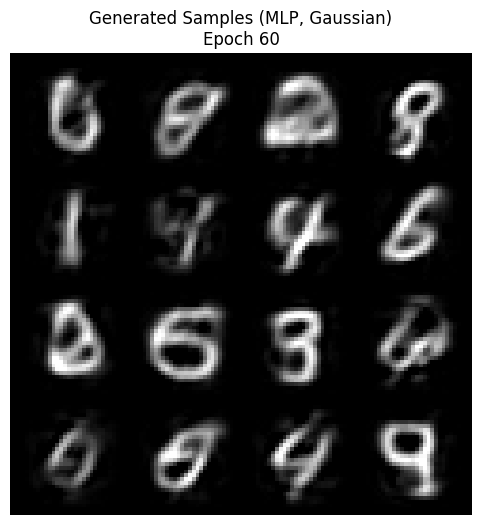

Epoch 61/100, Avg Loss: 31.1929
Epoch 62/100, Avg Loss: 31.1901
Epoch 62/100, Avg Loss: 31.1901
Epoch 63/100, Avg Loss: 31.1693
Epoch 63/100, Avg Loss: 31.1693
Epoch 64/100, Avg Loss: 31.1490
Epoch 64/100, Avg Loss: 31.1490
Epoch 65/100, Avg Loss: 31.1245
Epoch 65/100, Avg Loss: 31.1245
Epoch 66/100, Avg Loss: 31.1237
Epoch 66/100, Avg Loss: 31.1237
Epoch 67/100, Avg Loss: 31.1209
Epoch 67/100, Avg Loss: 31.1209
Epoch 68/100, Avg Loss: 31.0997
Epoch 68/100, Avg Loss: 31.0997
Epoch 69/100, Avg Loss: 31.0634
Epoch 69/100, Avg Loss: 31.0634
Epoch 70/100, Avg Loss: 31.0489
Epoch 70/100, Avg Loss: 31.0489
Epoch 71/100, Avg Loss: 31.0373
Epoch 71/100, Avg Loss: 31.0373
Epoch 72/100, Avg Loss: 31.0455
Epoch 72/100, Avg Loss: 31.0455
Epoch 73/100, Avg Loss: 31.0006
Epoch 73/100, Avg Loss: 31.0006
Epoch 74/100, Avg Loss: 30.9953
Epoch 74/100, Avg Loss: 30.9953
Epoch 75/100, Avg Loss: 30.9899
Epoch 75/100, Avg Loss: 30.9899
Epoch 76/100, Avg Loss: 30.9723
Epoch 76/100, Avg Loss: 30.9723
Epoch 77

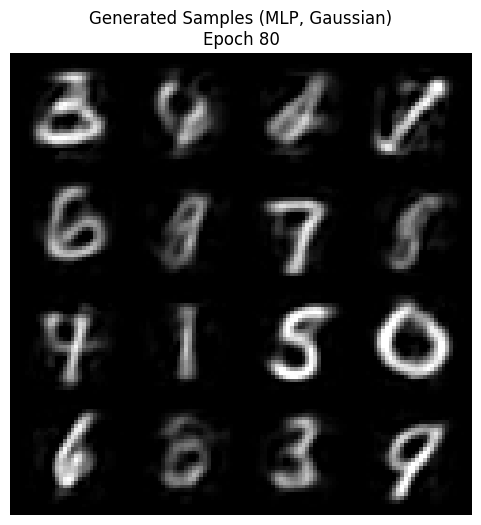

Epoch 81/100, Avg Loss: 30.9120
Epoch 82/100, Avg Loss: 30.8725
Epoch 82/100, Avg Loss: 30.8725
Epoch 83/100, Avg Loss: 30.8894
Epoch 83/100, Avg Loss: 30.8894
Epoch 84/100, Avg Loss: 30.8867
Epoch 84/100, Avg Loss: 30.8867
Epoch 85/100, Avg Loss: 30.8733
Epoch 85/100, Avg Loss: 30.8733
Epoch 86/100, Avg Loss: 30.8316
Epoch 86/100, Avg Loss: 30.8316
Epoch 87/100, Avg Loss: 30.8352
Epoch 87/100, Avg Loss: 30.8352
Epoch 88/100, Avg Loss: 30.8301
Epoch 88/100, Avg Loss: 30.8301
Epoch 89/100, Avg Loss: 30.8045
Epoch 89/100, Avg Loss: 30.8045
Epoch 90/100, Avg Loss: 30.7930
Epoch 90/100, Avg Loss: 30.7930
Epoch 91/100, Avg Loss: 30.7962
Epoch 91/100, Avg Loss: 30.7962
Epoch 92/100, Avg Loss: 30.8015
Epoch 92/100, Avg Loss: 30.8015
Epoch 93/100, Avg Loss: 30.7796
Epoch 93/100, Avg Loss: 30.7796
Epoch 94/100, Avg Loss: 30.7771
Epoch 94/100, Avg Loss: 30.7771
Epoch 95/100, Avg Loss: 30.7662
Epoch 95/100, Avg Loss: 30.7662
Epoch 96/100, Avg Loss: 30.7516
Epoch 96/100, Avg Loss: 30.7516
Epoch 97

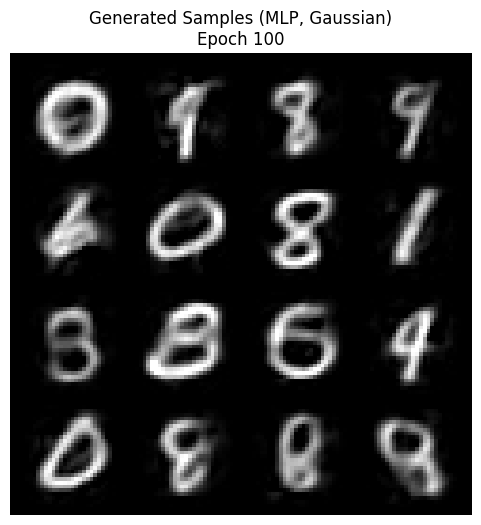

--- Experiment Finished: MLP, Gaussian ---


In [3]:
run_experiment(
    model_type="mlp",
    likelihood="gaussian",
    epochs=100,
    batch_size=1024,
    latent_dim=20,
    mlp_hidden_dim=256,
    show_every=20,
    lr=1e-3,
)

You can see that when the likelihood is modeled as a Gaussian, the generated images tend to be blurrier compared to those produced using a Bernoulli likelihood. This difference becomes clearer when you consider the loss functions involved—MSE versus BCE. While both losses encourage the predictions to match the target values, BCE tends to push the outputs more aggressively toward the extremes (closer to 0 or 1). In contrast, MSE, consistent with the Gaussian assumption, doesn't penalize small deviations as strongly, resulting in smoother, often blurrier reconstructions.


--- Starting Experiment ---
Model Type: CNN, Likelihood: Bernoulli
Epochs: 100, Batch Size: 1024, Latent Dim: 20, LR: 0.001
Using device: cuda
Trainable Parameters: 382,089
Epoch 1/100, Avg Loss: 266.1590
Epoch 1/100, Avg Loss: 266.1590
Epoch 2/100, Avg Loss: 205.7464
Epoch 2/100, Avg Loss: 205.7464
Epoch 3/100, Avg Loss: 180.3739
Epoch 3/100, Avg Loss: 180.3739
Epoch 4/100, Avg Loss: 147.6950
Epoch 4/100, Avg Loss: 147.6950
Epoch 5/100, Avg Loss: 127.5345
Epoch 5/100, Avg Loss: 127.5345
Epoch 6/100, Avg Loss: 118.1554
Epoch 6/100, Avg Loss: 118.1554
Epoch 7/100, Avg Loss: 113.4123
Epoch 7/100, Avg Loss: 113.4123
Epoch 8/100, Avg Loss: 110.3831
Epoch 8/100, Avg Loss: 110.3831
Epoch 9/100, Avg Loss: 108.3184
Epoch 9/100, Avg Loss: 108.3184
Epoch 10/100, Avg Loss: 107.0966
Epoch 10/100, Avg Loss: 107.0966
Epoch 11/100, Avg Loss: 105.9871
Epoch 11/100, Avg Loss: 105.9871
Epoch 12/100, Avg Loss: 105.3412
Epoch 12/100, Avg Loss: 105.3412
Epoch 13/100, Avg Loss: 104.5654
Epoch 13/100, Avg L

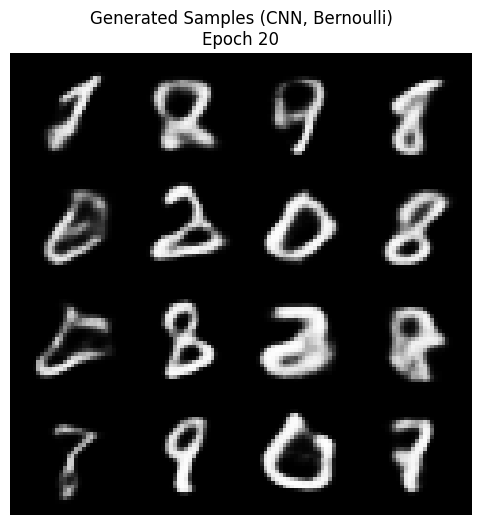

Epoch 21/100, Avg Loss: 101.5579
Epoch 22/100, Avg Loss: 101.3981
Epoch 22/100, Avg Loss: 101.3981
Epoch 23/100, Avg Loss: 101.1011
Epoch 23/100, Avg Loss: 101.1011
Epoch 24/100, Avg Loss: 100.9110
Epoch 24/100, Avg Loss: 100.9110
Epoch 25/100, Avg Loss: 100.6579
Epoch 25/100, Avg Loss: 100.6579
Epoch 26/100, Avg Loss: 100.5680
Epoch 26/100, Avg Loss: 100.5680
Epoch 27/100, Avg Loss: 100.4303
Epoch 27/100, Avg Loss: 100.4303
Epoch 28/100, Avg Loss: 100.1979
Epoch 28/100, Avg Loss: 100.1979
Epoch 29/100, Avg Loss: 100.1691
Epoch 29/100, Avg Loss: 100.1691
Epoch 30/100, Avg Loss: 99.9799
Epoch 30/100, Avg Loss: 99.9799
Epoch 31/100, Avg Loss: 99.8541
Epoch 31/100, Avg Loss: 99.8541
Epoch 32/100, Avg Loss: 99.6599
Epoch 32/100, Avg Loss: 99.6599
Epoch 33/100, Avg Loss: 99.6425
Epoch 33/100, Avg Loss: 99.6425
Epoch 34/100, Avg Loss: 99.5366
Epoch 34/100, Avg Loss: 99.5366
Epoch 35/100, Avg Loss: 99.4291
Epoch 35/100, Avg Loss: 99.4291
Epoch 36/100, Avg Loss: 99.2250
Epoch 36/100, Avg Loss:

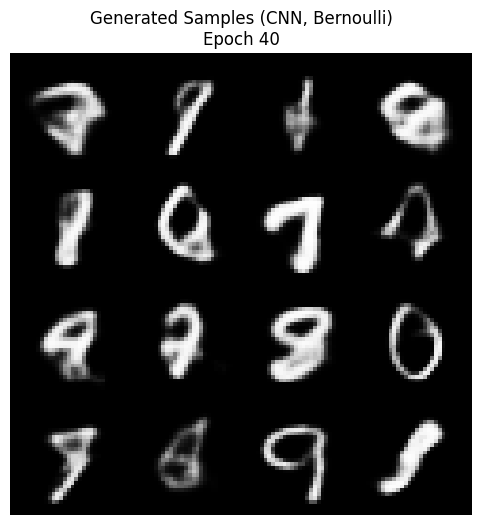

Epoch 41/100, Avg Loss: 98.7716
Epoch 42/100, Avg Loss: 98.7784
Epoch 42/100, Avg Loss: 98.7784
Epoch 43/100, Avg Loss: 98.6124
Epoch 43/100, Avg Loss: 98.6124
Epoch 44/100, Avg Loss: 98.6955
Epoch 44/100, Avg Loss: 98.6955
Epoch 45/100, Avg Loss: 98.4444
Epoch 45/100, Avg Loss: 98.4444
Epoch 46/100, Avg Loss: 98.3745
Epoch 46/100, Avg Loss: 98.3745
Epoch 47/100, Avg Loss: 98.3165
Epoch 47/100, Avg Loss: 98.3165
Epoch 48/100, Avg Loss: 98.2491
Epoch 48/100, Avg Loss: 98.2491
Epoch 49/100, Avg Loss: 98.2470
Epoch 49/100, Avg Loss: 98.2470
Epoch 50/100, Avg Loss: 98.0403
Epoch 50/100, Avg Loss: 98.0403
Epoch 51/100, Avg Loss: 98.0238
Epoch 51/100, Avg Loss: 98.0238
Epoch 52/100, Avg Loss: 97.9662
Epoch 52/100, Avg Loss: 97.9662
Epoch 53/100, Avg Loss: 97.9532
Epoch 53/100, Avg Loss: 97.9532
Epoch 54/100, Avg Loss: 97.9889
Epoch 54/100, Avg Loss: 97.9889
Epoch 55/100, Avg Loss: 97.7699
Epoch 55/100, Avg Loss: 97.7699
Epoch 56/100, Avg Loss: 97.7370
Epoch 56/100, Avg Loss: 97.7370
Epoch 57

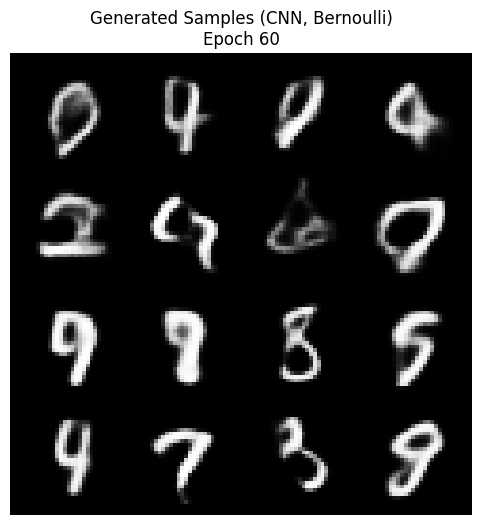

Epoch 61/100, Avg Loss: 97.5165
Epoch 62/100, Avg Loss: 97.4347
Epoch 62/100, Avg Loss: 97.4347
Epoch 63/100, Avg Loss: 97.4544
Epoch 63/100, Avg Loss: 97.4544
Epoch 64/100, Avg Loss: 97.3618
Epoch 64/100, Avg Loss: 97.3618
Epoch 65/100, Avg Loss: 97.2558
Epoch 65/100, Avg Loss: 97.2558
Epoch 66/100, Avg Loss: 97.2779
Epoch 66/100, Avg Loss: 97.2779
Epoch 67/100, Avg Loss: 97.2217
Epoch 67/100, Avg Loss: 97.2217
Epoch 68/100, Avg Loss: 97.2126
Epoch 68/100, Avg Loss: 97.2126
Epoch 69/100, Avg Loss: 97.2866
Epoch 69/100, Avg Loss: 97.2866
Epoch 70/100, Avg Loss: 97.1149
Epoch 70/100, Avg Loss: 97.1149
Epoch 71/100, Avg Loss: 97.0161
Epoch 71/100, Avg Loss: 97.0161
Epoch 72/100, Avg Loss: 97.0396
Epoch 72/100, Avg Loss: 97.0396
Epoch 73/100, Avg Loss: 96.9088
Epoch 73/100, Avg Loss: 96.9088
Epoch 74/100, Avg Loss: 96.9344
Epoch 74/100, Avg Loss: 96.9344
Epoch 75/100, Avg Loss: 96.8189
Epoch 75/100, Avg Loss: 96.8189
Epoch 76/100, Avg Loss: 96.8240
Epoch 76/100, Avg Loss: 96.8240
Epoch 77

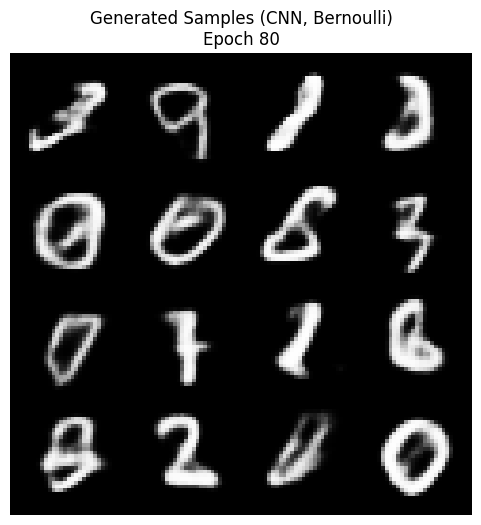

Epoch 81/100, Avg Loss: 96.6800
Epoch 82/100, Avg Loss: 96.6478
Epoch 82/100, Avg Loss: 96.6478
Epoch 83/100, Avg Loss: 96.5893
Epoch 83/100, Avg Loss: 96.5893
Epoch 84/100, Avg Loss: 96.6073
Epoch 84/100, Avg Loss: 96.6073
Epoch 85/100, Avg Loss: 96.4988
Epoch 85/100, Avg Loss: 96.4988
Epoch 86/100, Avg Loss: 96.4572
Epoch 86/100, Avg Loss: 96.4572
Epoch 87/100, Avg Loss: 96.5121
Epoch 87/100, Avg Loss: 96.5121
Epoch 88/100, Avg Loss: 96.4100
Epoch 88/100, Avg Loss: 96.4100
Epoch 89/100, Avg Loss: 96.4764
Epoch 89/100, Avg Loss: 96.4764
Epoch 90/100, Avg Loss: 96.4223
Epoch 90/100, Avg Loss: 96.4223
Epoch 91/100, Avg Loss: 96.3094
Epoch 91/100, Avg Loss: 96.3094
Epoch 92/100, Avg Loss: 96.4109
Epoch 92/100, Avg Loss: 96.4109
Epoch 93/100, Avg Loss: 96.3812
Epoch 93/100, Avg Loss: 96.3812
Epoch 94/100, Avg Loss: 96.2053
Epoch 94/100, Avg Loss: 96.2053
Epoch 95/100, Avg Loss: 96.2514
Epoch 95/100, Avg Loss: 96.2514
Epoch 96/100, Avg Loss: 96.2680
Epoch 96/100, Avg Loss: 96.2680
Epoch 97

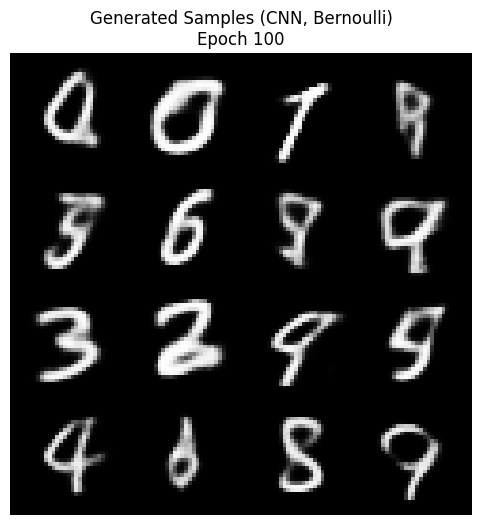

--- Experiment Finished: CNN, Bernoulli ---


In [4]:
run_experiment(
    model_type="cnn",
    likelihood="bernoulli",
    epochs=100,
    batch_size=1024,
    latent_dim=20,
    show_every=20,
    lr=1e-3,
)


--- Starting Experiment ---
Model Type: CNN, Likelihood: Gaussian
Epochs: 100, Batch Size: 1024, Latent Dim: 20, LR: 0.001
Using device: cuda
Trainable Parameters: 382,089
Epoch 1/100, Avg Loss: 64.4522
Epoch 1/100, Avg Loss: 64.4522
Epoch 2/100, Avg Loss: 49.6543
Epoch 2/100, Avg Loss: 49.6543
Epoch 3/100, Avg Loss: 42.0398
Epoch 3/100, Avg Loss: 42.0398
Epoch 4/100, Avg Loss: 37.3167
Epoch 4/100, Avg Loss: 37.3167
Epoch 5/100, Avg Loss: 35.0618
Epoch 5/100, Avg Loss: 35.0618
Epoch 6/100, Avg Loss: 33.8259
Epoch 6/100, Avg Loss: 33.8259
Epoch 7/100, Avg Loss: 33.0318
Epoch 7/100, Avg Loss: 33.0318
Epoch 8/100, Avg Loss: 32.4742
Epoch 8/100, Avg Loss: 32.4742
Epoch 9/100, Avg Loss: 32.0516
Epoch 9/100, Avg Loss: 32.0516
Epoch 10/100, Avg Loss: 31.7581
Epoch 10/100, Avg Loss: 31.7581
Epoch 11/100, Avg Loss: 31.4552
Epoch 11/100, Avg Loss: 31.4552
Epoch 12/100, Avg Loss: 31.2309
Epoch 12/100, Avg Loss: 31.2309
Epoch 13/100, Avg Loss: 31.0032
Epoch 13/100, Avg Loss: 31.0032
Epoch 14/100,

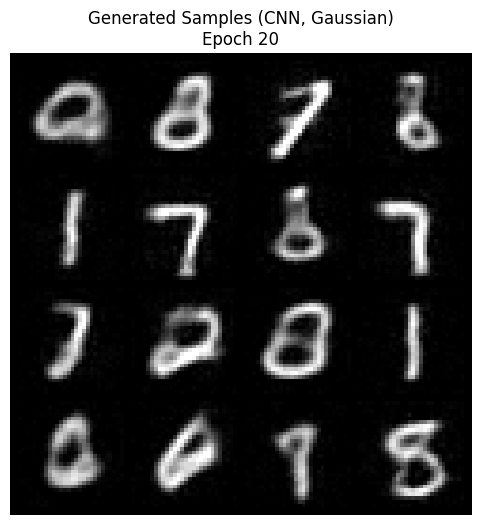

Epoch 21/100, Avg Loss: 29.9821
Epoch 22/100, Avg Loss: 29.8994
Epoch 22/100, Avg Loss: 29.8994
Epoch 23/100, Avg Loss: 29.8670
Epoch 23/100, Avg Loss: 29.8670
Epoch 24/100, Avg Loss: 29.7861
Epoch 24/100, Avg Loss: 29.7861
Epoch 25/100, Avg Loss: 29.7198
Epoch 25/100, Avg Loss: 29.7198
Epoch 26/100, Avg Loss: 29.6549
Epoch 26/100, Avg Loss: 29.6549
Epoch 27/100, Avg Loss: 29.6029
Epoch 27/100, Avg Loss: 29.6029
Epoch 28/100, Avg Loss: 29.5088
Epoch 28/100, Avg Loss: 29.5088
Epoch 29/100, Avg Loss: 29.4325
Epoch 29/100, Avg Loss: 29.4325
Epoch 30/100, Avg Loss: 29.4067
Epoch 30/100, Avg Loss: 29.4067
Epoch 31/100, Avg Loss: 29.3365
Epoch 31/100, Avg Loss: 29.3365
Epoch 32/100, Avg Loss: 29.3118
Epoch 32/100, Avg Loss: 29.3118
Epoch 33/100, Avg Loss: 29.2512
Epoch 33/100, Avg Loss: 29.2512
Epoch 34/100, Avg Loss: 29.2349
Epoch 34/100, Avg Loss: 29.2349
Epoch 35/100, Avg Loss: 29.2089
Epoch 35/100, Avg Loss: 29.2089
Epoch 36/100, Avg Loss: 29.2166
Epoch 36/100, Avg Loss: 29.2166
Epoch 37

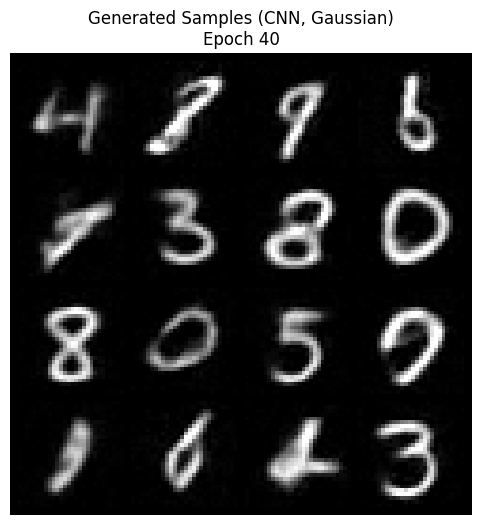

Epoch 41/100, Avg Loss: 28.9682
Epoch 42/100, Avg Loss: 28.9268
Epoch 42/100, Avg Loss: 28.9268
Epoch 43/100, Avg Loss: 28.9405
Epoch 43/100, Avg Loss: 28.9405
Epoch 44/100, Avg Loss: 28.9220
Epoch 44/100, Avg Loss: 28.9220
Epoch 45/100, Avg Loss: 28.8535
Epoch 45/100, Avg Loss: 28.8535
Epoch 46/100, Avg Loss: 28.8467
Epoch 46/100, Avg Loss: 28.8467
Epoch 47/100, Avg Loss: 28.7978
Epoch 47/100, Avg Loss: 28.7978
Epoch 48/100, Avg Loss: 28.7823
Epoch 48/100, Avg Loss: 28.7823
Epoch 49/100, Avg Loss: 28.7603
Epoch 49/100, Avg Loss: 28.7603
Epoch 50/100, Avg Loss: 28.7580
Epoch 50/100, Avg Loss: 28.7580
Epoch 51/100, Avg Loss: 28.7022
Epoch 51/100, Avg Loss: 28.7022
Epoch 52/100, Avg Loss: 28.7023
Epoch 52/100, Avg Loss: 28.7023
Epoch 53/100, Avg Loss: 28.6824
Epoch 53/100, Avg Loss: 28.6824
Epoch 54/100, Avg Loss: 28.8026
Epoch 54/100, Avg Loss: 28.8026
Epoch 55/100, Avg Loss: 28.6225
Epoch 55/100, Avg Loss: 28.6225
Epoch 56/100, Avg Loss: 28.5909
Epoch 56/100, Avg Loss: 28.5909
Epoch 57

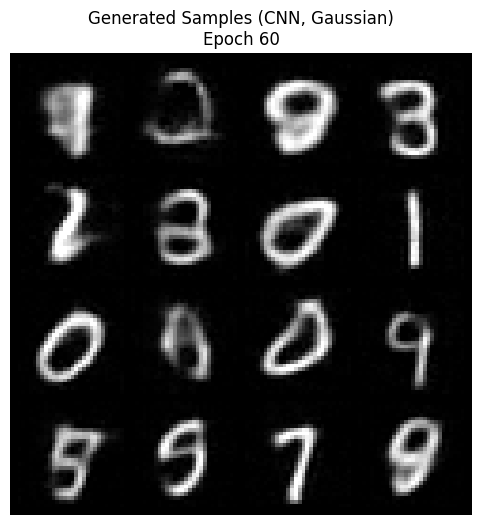

Epoch 61/100, Avg Loss: 28.5089
Epoch 62/100, Avg Loss: 28.4813
Epoch 62/100, Avg Loss: 28.4813
Epoch 63/100, Avg Loss: 28.4290
Epoch 63/100, Avg Loss: 28.4290
Epoch 64/100, Avg Loss: 28.4645
Epoch 64/100, Avg Loss: 28.4645
Epoch 65/100, Avg Loss: 28.4493
Epoch 65/100, Avg Loss: 28.4493
Epoch 66/100, Avg Loss: 28.3961
Epoch 66/100, Avg Loss: 28.3961
Epoch 67/100, Avg Loss: 28.3743
Epoch 67/100, Avg Loss: 28.3743
Epoch 68/100, Avg Loss: 28.4417
Epoch 68/100, Avg Loss: 28.4417
Epoch 69/100, Avg Loss: 28.3277
Epoch 69/100, Avg Loss: 28.3277
Epoch 70/100, Avg Loss: 28.3369
Epoch 70/100, Avg Loss: 28.3369
Epoch 71/100, Avg Loss: 28.3205
Epoch 71/100, Avg Loss: 28.3205
Epoch 72/100, Avg Loss: 28.3095
Epoch 72/100, Avg Loss: 28.3095
Epoch 73/100, Avg Loss: 28.3014
Epoch 73/100, Avg Loss: 28.3014
Epoch 74/100, Avg Loss: 28.2545
Epoch 74/100, Avg Loss: 28.2545
Epoch 75/100, Avg Loss: 28.2370
Epoch 75/100, Avg Loss: 28.2370
Epoch 76/100, Avg Loss: 28.2577
Epoch 76/100, Avg Loss: 28.2577
Epoch 77

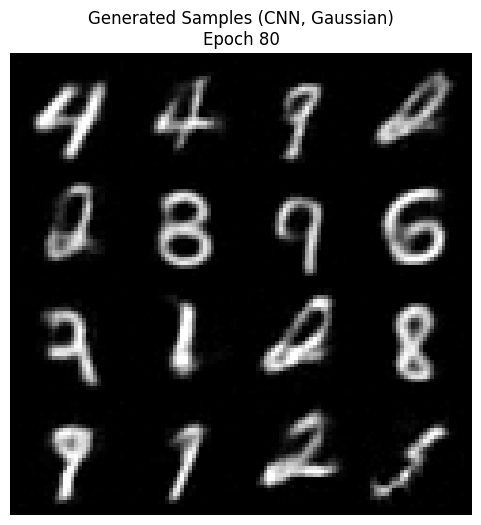

Epoch 81/100, Avg Loss: 28.2231
Epoch 82/100, Avg Loss: 28.1383
Epoch 82/100, Avg Loss: 28.1383
Epoch 83/100, Avg Loss: 28.1349
Epoch 83/100, Avg Loss: 28.1349
Epoch 84/100, Avg Loss: 28.1421
Epoch 84/100, Avg Loss: 28.1421
Epoch 85/100, Avg Loss: 28.1182
Epoch 85/100, Avg Loss: 28.1182
Epoch 86/100, Avg Loss: 28.1218
Epoch 86/100, Avg Loss: 28.1218
Epoch 87/100, Avg Loss: 28.0612
Epoch 87/100, Avg Loss: 28.0612
Epoch 88/100, Avg Loss: 28.0983
Epoch 88/100, Avg Loss: 28.0983
Epoch 89/100, Avg Loss: 28.0682
Epoch 89/100, Avg Loss: 28.0682
Epoch 90/100, Avg Loss: 28.0653
Epoch 90/100, Avg Loss: 28.0653
Epoch 91/100, Avg Loss: 28.0691
Epoch 91/100, Avg Loss: 28.0691
Epoch 92/100, Avg Loss: 28.0103
Epoch 92/100, Avg Loss: 28.0103
Epoch 93/100, Avg Loss: 27.9930
Epoch 93/100, Avg Loss: 27.9930
Epoch 94/100, Avg Loss: 28.0126
Epoch 94/100, Avg Loss: 28.0126
Epoch 95/100, Avg Loss: 27.9979
Epoch 95/100, Avg Loss: 27.9979
Epoch 96/100, Avg Loss: 27.9757
Epoch 96/100, Avg Loss: 27.9757
Epoch 97

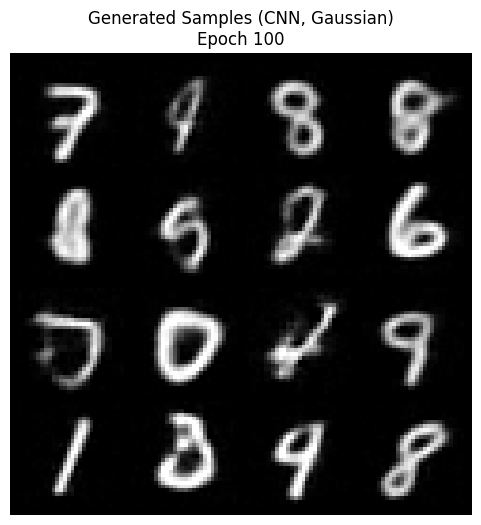

--- Experiment Finished: CNN, Gaussian ---


In [5]:
run_experiment(
    model_type="cnn",
    likelihood="gaussian",
    epochs=100,
    batch_size=1024,
    latent_dim=20,
    show_every=20,
    lr=1e-3,
)

As you can see, CNN produces better images. Using a neural network architecture that's more tailored to specific data type helps, e.g., CNNs for images, LSTMs for sequential data, etc.